<a href="https://colab.research.google.com/github/LeraKalinina/Demo/blob/main/%D0%9C%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B8_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_0610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/telecom_churn.csv")

In [ ]:
df["International plan"] = pd.factorize(df["International plan"])[0]
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]
df["Churn"] = df["Churn"].astype("int")
states = df["State"]
y = df["Churn"]
X=df.drop(["State", "Churn"], axis=1)

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [ ]:
from sklearn.model_selection import  train_test_split

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=30
)

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, random_state=30)
knn = KNeighborsClassifier(n_neighbors=20)
logreg = LogisticRegression()
forest = RandomForestClassifier()
grad = GradientBoostingClassifier()

In [ ]:
%%time
tree.fit(X_train, y_train)

CPU times: user 28.3 ms, sys: 0 ns, total: 28.3 ms
Wall time: 32.9 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=30, splitter='best')

In [ ]:
%%time
knn.fit(X_train, y_train)

CPU times: user 6.36 ms, sys: 31 µs, total: 6.39 ms
Wall time: 6.44 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [ ]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 92 ms, sys: 66.6 ms, total: 159 ms
Wall time: 91.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
%%time
forest.fit(X_train, y_train)

CPU times: user 641 ms, sys: 1.41 ms, total: 643 ms
Wall time: 648 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
%%time
grad.fit(X_train, y_train)

CPU times: user 878 ms, sys: 0 ns, total: 878 ms
Wall time: 883 ms


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Проверим качество модели, вычислив аккуратность

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов

In [ ]:
from sklearn.metrics import accuracy_score

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад.

In [ ]:
tree_pred = tree.predict(X_test)
accuracy_score(y_test, tree_pred)

0.941

In [ ]:
knn_pred = knn.predict(X_test)
accuracy_score(y_test, knn_pred)

0.879

In [ ]:
logreg_pred = logreg.predict(X_test)
accuracy_score(y_test, logreg_pred)

0.873

In [ ]:
forest_pred = forest.predict(X_test)
accuracy_score(y_test, forest_pred)

0.948

In [ ]:
grad_pred = grad.predict(X_test)
accuracy_score(y_test, grad_pred)

0.953

Построим матрицу неточностей и вычислим точность, полноту и F1

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
tree_matrix=confusion_matrix(y_test, tree_pred)# матрица неточностей для дерева решений
tree_matrix

array([[848,  19],
       [ 40,  93]])

In [ ]:
tree_matrix=confusion_matrix(y_test, knn_pred)# матрица неточностей для KNN
tree_matrix

array([[859,   8],
       [113,  20]])

In [ ]:
tree_matrix=confusion_matrix(y_test, logreg_pred)
tree_matrix

array([[858,   9],
       [118,  15]])

In [ ]:
tree_matrix=confusion_matrix(y_test, forest_pred)
tree_matrix

array([[860,   7],
       [ 45,  88]])

0 Lejat + sosat


In [ ]:
report = classification_report(y_test, tree_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       867
           1       0.83      0.70      0.76       133

    accuracy                           0.94      1000
   macro avg       0.89      0.84      0.86      1000
weighted avg       0.94      0.94      0.94      1000



In [ ]:
report = classification_report(y_test, knn_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       867
           1       0.71      0.15      0.25       133

    accuracy                           0.88      1000
   macro avg       0.80      0.57      0.59      1000
weighted avg       0.86      0.88      0.84      1000



Вычислим ROC AUC

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
auc_DT = roc_auc_score(y_test, tree_pred)
auc_DT

0.8386667360442629

In [ ]:
auc_KNN = roc_auc_score(y_test, knn_pred)
auc_KNN

0.5705743597748697

Построим ROC-кривую

In [ ]:
y_pred_tree = tree.predict_proba(X_test)[:,1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_tree)

In [ ]:
y_pred_knn = knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)

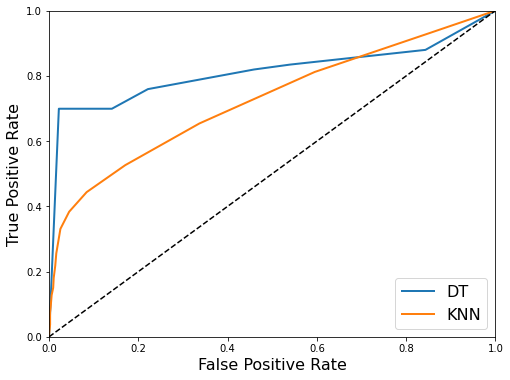

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, linewidth=2, label='DT')
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='KNN')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)

plt.show()